# AutoCSV Dev

WNixalo –– 2018/6/2-3

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from cifar_utils import count_files

In [3]:
PATH = Path('data/cifar10')

## Dataset Population

In [4]:
with open(PATH/'labels.txt') as f:
    text = f.read()
# print(text)
cats = text.split('\n')[:-1]
cats

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
cat_pops = {cat:count_files(PATH/'train'/cat) for cat in cats}
cat_pops

{'airplane': 4250,
 'automobile': 4250,
 'bird': 4250,
 'cat': 4250,
 'deer': 4250,
 'dog': 4250,
 'frog': 4250,
 'horse': 4250,
 'ship': 4250,
 'truck': 4250}

In [6]:
cols = dict()
cols['cat'],cols['pop'] = zip(*cat_pops.items())

In [7]:
df = pd.DataFrame(cols)
df.head()

,cat,pop
0,airplane,4250
1,automobile,4250
2,bird,4250
3,cat,4250
4,deer,4250


(4250.0, 0.0)

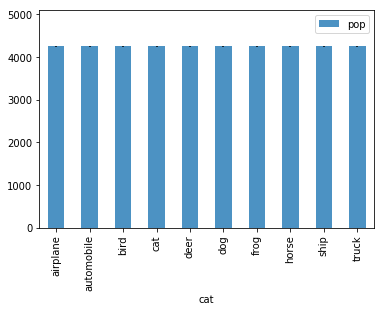

In [8]:
df.plot.bar(x=df[df.columns[0]], ylim=(0,1.2*df[df.columns[1]].values.max()), 
            yerr=max(df.mean()[0]*0.005, df.std()[0]), alpha=.8)
df.mean()[0], df.std()[0]

### Uneven data set:

In [9]:
def plot_pops(df, print_ms=True):
    if print_ms: print(f"{df.mean()[0]:.2f} {df.std()[0]:.2f}")
    df.plot.bar(x=df[df.columns[0]], ylim=(0,1.2*df[df.columns[1]].values.max()), 
            yerr=max(df.mean()[0]*0.005, df.std()[0]), alpha=.8)
    df.mean()[0], df.std()[0]

In [10]:
df_backup = df.copy()

In [11]:
# df.at[2,'cat'] # equals 'bird'
df.at[2, 'pop'] /= 2 # 4250 -> 2125
df.at[2,'pop'] # for editing df values see: https://stackoverflow.com/a/13842286

2125

4037.50 671.98


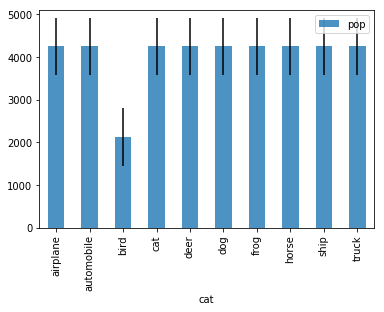

In [12]:
plot_pops(df)

In [13]:
df.std()[0]

671.9840027857806

## AutoCSV

In [14]:
# generate a csv from a dataset
def generate_csv(path, labelmap=None, folder='train'):
    """Infers a csv from directory structure. 
       `labelmap` is a dictionary mapping class folders to class names.
       Class names are taken from class folder names if no mapping is provided.
       For Single-Category Classification.
    """
    # find categories
    catfolders = [f for f in os.listdir(path/folder) if (path/folder/f).is_dir()]
    if labelmap is None: labelmap = {cf:cf for cf in catfolders}

    rows = []

    for cat in catfolders:
        catpath = path/folder/cat
        fpaths  = list(map(lambda x: cat+'/'+x, os.listdir(catpath)))
        rows.extend(list(zip(fpaths,[labelmap[cat] for i in range(len(fpaths))])))

    df = pd.DataFrame(rows, columns=['file','class'])
    return df

In [15]:
%%time
csv = generate_csv(PATH)

CPU times: user 68.8 ms, sys: 52.1 ms, total: 121 ms
Wall time: 122 ms


In [16]:
csv.sample(n=10)

,file,class
6483,dog/20688_dog.png,dog
12388,truck/1602_truck.png,truck
16061,bird/14294_bird.png,bird
18073,airplane/18106_airplane.png,airplane
42118,automobile/46162_automobile.png,automobile
39891,automobile/33188_automobile.png,automobile
17797,airplane/38187_airplane.png,airplane
1668,cat/45885_cat.png,cat
22111,ship/24451_ship.png,ship
13452,bird/37374_bird.png,bird


## CSV-based Pop Counting

In [17]:
def pops_from_df(df, catdx=1, colnames=['cat','pop']):
    """Extracts category populations from a DataFrame.
       If `colnames=None`: returns a dictionary, otherwise
       a dataframe with `colnames` columns.
    """
    catcol = df.columns[catdx] # prevsly: y = df.columns[ydx]
    cats = df[catcol].unique()
    pops = [df[df[catcol]==cat].count()[0] for cat in cats] # prevsly: y -> catcol
    cat_pops = {cat:pop for cat,pop in zip(cats,pops)}
    
    if colnames:
        cat_pops = list(zip(cats,pops))
        cat_pops = pd.DataFrame(cat_pops, columns=colnames)
    else:
        cat_pops = {cat:pop for cat,pop in zip(cats,pops)}
    
    return cat_pops

In [18]:
pops_from_df(csv, colnames=None)

{'cat': 4250,
 'dog': 4250,
 'truck': 4250,
 'bird': 4250,
 'airplane': 4250,
 'ship': 4250,
 'frog': 4250,
 'horse': 4250,
 'deer': 4250,
 'automobile': 4250}

4250.00 0.00


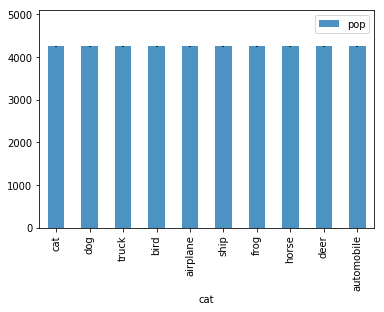

In [19]:
plot_pops(pops_from_df(csv))

## CSV sampling

Retreive a portion of the csv

In [20]:
def csv_subset(df, catdx=1, p=0.5):
    """Returns a percetnage of the original dataset, sampled uniformly by category."""
    if type(p)==int: p /= df.count()
    
    catcol = df.columns[catdx]
    cats   = df[catcol].unique()
    df_slice  = df[catcol]
    keep_idxs = np.array([], dtype=np.int64)
    
    for cat in cats:
        cat_idxs = np.where(df_slice==cat)[0]
        n = max(1, int(len(cat_idxs)*p))
        keep_idxs = np.concatenate((keep_idxs, np.random.choice(cat_idxs, size=n, replace=False)))
    
    return df.iloc[keep_idxs]

In [410]:
full_df  = generate_csv(PATH)
cat_pops = pops_from_df(full_df)

full_df.count()[0]

42500

In [411]:
new_csv = csv_subset(full_df)
new_csv.count()[0]

21250

In [412]:
pops_from_df(new_csv)

,cat,pop
0,cat,2125
1,dog,2125
2,truck,2125
3,bird,2125
4,airplane,2125
5,ship,2125
6,frog,2125
7,horse,2125
8,deer,2125
9,automobile,2125


In [413]:
new_csv.head()

,file,class
2311,cat/14032_cat.png,cat
3438,cat/6348_cat.png,cat
2914,cat/38894_cat.png,cat
3382,cat/18582_cat.png,cat
80,cat/11476_cat.png,cat


In [421]:
np.unique(new_csv[new_csv['class']=='cat'].as_matrix()[:,0]).shape # check: no repeats

(2125,)

## Dataset Smoothing

"Smooth" out category populations to within a specified standard deviation.

In [950]:
def smooth_csv_dataset(df, eps=0.1, full_df=None, catdx=1):
    """'Smooths' out a dataset by adding copied samples.
    
        For use with single-label classification (2-column) CSVs."""
    
    # result DF and sampling DF
    new_df  = df.copy()
    full_df = df if full_df is None else full_df
    # get category column name
    catcol = df.columns[catdx]
    
    # get category populations & calculate desired range
    cat_pops = pops_from_df(df)
    c_totals = cat_pops.as_matrix(columns=['pop'])
    sd       = eps * c_totals.mean()
    # Normalize category sizes
    c_norm     = c_totals/c_totals.max()
    new_mean   = c_totals.max() - sd
    new_totals = (2*sd * c_norm + (new_mean - sd)).astype(int)
    
    # Increase category sizes by differences
    diffs     = new_totals - c_totals
    cats      = cat_pops['cat'].values
    copy_idxs = []
    
    for i,cat in enumerate(cats):
        diff         = diffs[i]
        cat_idxs     = np.where(full_df[catcol]==cat)[0]
        full_cat_pop = len(cat_idxs)
        
        # if the difference is more than Nx greater, copy the whole category N times
        if diff > full_cat_pop:
            n_copy = int(diff) // full_cat_pop
            diff  -= n_copy * full_cat_pop
            for i in range(n_copy): copy_idxs.extend(cat_idxs)
        copy_idxs.extend(np.random.choice(cat_idxs, size=diff, replace=False))
    
    copy_rows = full_df.iloc[copy_idxs]
    new_df    = new_df.append(copy_rows)
    
    return new_df

In [959]:
def basic_plot2(c_totals=c_totals, sd=sd, oldmean=None, catlist=None):
    sa,mean = c_totals.std(),c_totals.mean() if oldmean is None else oldmean
    plt.bar(x=range(len(c_totals)),height=c_totals, alpha=0.4, color='k');
    plt.axhline(y=mean,c='r'); plt.axhline(y=mean+sd,c='k'); plt.axhline(y=mean-sd,c='k');
    if catlist is not None: plt.xticks(range(len(c_totals)), catlist, rotation=90)
    print(mean, (sd, sa))
    print(c_totals)

Makes this:

476.5 (47.650000000000006, 81.13599694340361)
[517 513 497 477 510 500 514 236 487 514]


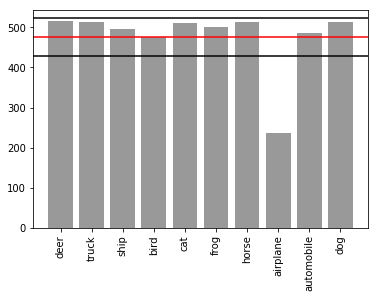

In [963]:
df = generate_csv(PATH)

skewed_df = df.sample(n=5000)
drop_idxs = np.where(skewed_df['class']=='airplane')[0]
drop_idxs = np.random.choice(drop_idxs, size=len(drop_idxs)//2, replace=False)
skewed_df.drop(skewed_df.index[drop_idxs], inplace=True)

cat_pops = pops_from_df(skewed_df)
c_totals = cat_pops.as_matrix(columns=['pop'])
catlist  = cat_pops.as_matrix(columns=['cat'])

eps = 0.1; sd = c_totals.mean()*eps

basic_plot2(c_totals=c_totals[:,0],sd=sd,catlist=catlist[:,0])

Become this:

509.1 (47.650000000000006, 14.895972610071489)
[517 516 513 509 515 513 516 465 511 516]


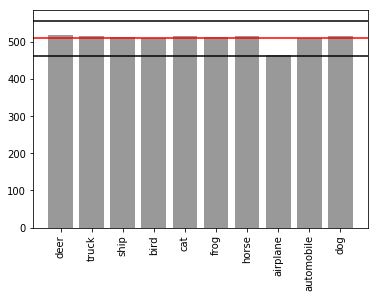

In [975]:
smoothed_df = smooth_csv_dataset(skewed_df, eps=eps, full_df=df)

cat_pops = pops_from_df(smoothed_df)
c_totals = cat_pops.as_matrix(columns=['pop'])
catlist  = cat_pops.as_matrix(columns=['cat'])

basic_plot2(c_totals=c_totals[:,0], sd=sd, catlist=catlist[:,0])

Looking at it another way:

469.35 (47.650000000000006, 14.895972610071489)
[517 516 513 509 515 513 516 465 511 516]


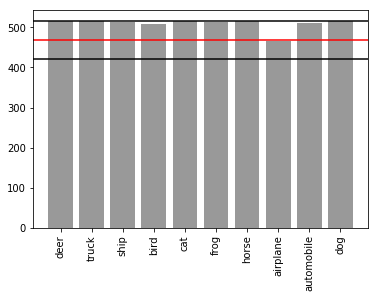

In [976]:
basic_plot2(c_totals=c_totals[:,0], sd=sd, catlist=catlist[:,0], oldmean=c_totals.max()-sd)

### Manual prototyping:

New algorithm:
```
set max to max category.
calculate new mean as 1 σδ below max.
normalize dataset to 1 σδ of new mean.
```

normalization:
- todo

In [462]:
def basic_plot():
    mean,sa = c_totals.mean(),c_totals.std()
    plt.bar(x=range(len(c_totals)),height=c_totals, alpha=0.4, color='k');
    plt.axhline(y=mean,c='r'); plt.axhline(y=mean+sd,c='k'); plt.axhline(y=mean-sd,c='k');
    print(mean, (sd, sa))
    print(c_totals)

In [500]:
df = generate_csv(PATH)

Getting a 'skewed' dataset from the original DataFrame

In [556]:
skewed_df = df.sample(n=5000)
counts = pops_from_df(skewed_df); counts.mean()[0], counts.std()[0]

(500.0, 22.181073012818835)

In [557]:
drop_idxs = np.where(skewed_df['class']=='dog')[0]
drop_idxs.shape

(532,)

In [558]:
drop_idxs = np.random.choice(drop_idxs, size=len(drop_idxs)//2, replace=False)
drop_idxs.shape

(266,)

In [584]:
skewed_df.drop(skewed_df.index[drop_idxs], inplace=True)
skewed_df.count()[0], np.where(skewed_df['class']=='dog')[0].shape[0]

(4734, 266)

473.40 75.34


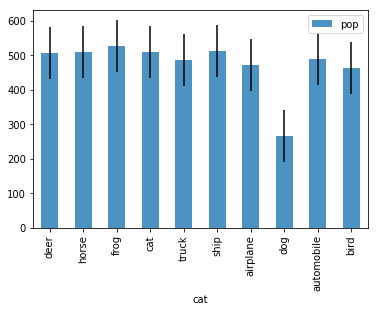

In [608]:
plot_pops(pops_from_df(skewed_df))

In this case with an ε of 10%, we'd want a standard deviation of about 47. It's currently at 75.

Modifying the algorithm to work on dataframes instead of integer arrays:

In [610]:
eps = 0.1

cat_pops = pops_from_df(skewed_df)
c_totals = cat_pops.as_matrix(columns=['pop'])

NumPy and Pandas seem to disagree on the standard deviation. Looks like by default they're [calculated subtly differently](https://stackoverflow.com/a/24984205).

In [611]:
c_totals.mean(), c_totals.std()

(473.4, 71.47335167739092)

In [631]:
sd = eps * c_totals.mean() # desired standard deviation

Normalize category sizes:

In [728]:
# normalize category sizes
c_normd = c_totals/c_totals.max()# - c_totals.min()/c_totals.max()
mean = c_totals.max() - sd
new_totals = (2*sd * c_normd + (mean - sd)).astype(int)

#display
print(c_totals.mean(),mean);print(c_totals.std(),new_totals.std()); list(zip(c_totals, new_totals))

473.4 477.65999999999997
71.47335167739092 12.867012085173464


[(array([506]), array([521])),
 (array([508]), array([521])),
 (array([525]), array([525])),
 (array([509]), array([522])),
 (array([486]), array([517])),
 (array([511]), array([522])),
 (array([471]), array([515])),
 (array([266]), array([478])),
 (array([488]), array([518])),
 (array([464]), array([513]))]

In [729]:
c_normd

array([[0.96380952],
       [0.96761905],
       [1.        ],
       [0.96952381],
       [0.92571429],
       [0.97333333],
       [0.89714286],
       [0.50666667],
       [0.92952381],
       [0.88380952]])

In [730]:
c_totals.max()

525

In [731]:
c_totals[:,0]

array([506, 508, 525, 509, 486, 511, 471, 266, 488, 464])

Looks like things are working to spec:

In [741]:
def basic_plot2(c_totals=c_totals, sd=sd, oldmean=None):
    sa,mean = c_totals.std(),c_totals.mean() if oldmean is None else oldmean
    plt.bar(x=range(len(c_totals)),height=c_totals, alpha=0.4, color='k');
    plt.axhline(y=mean,c='r'); plt.axhline(y=mean+sd,c='k'); plt.axhline(y=mean-sd,c='k');
    print(mean, (sd, sa))
    print(c_totals)

Showing the new distribution with original mean flanked by desired standard deviation:

477.65999999999997 (47.34, 12.867012085173464)
[521 521 525 522 517 522 515 478 518 513]


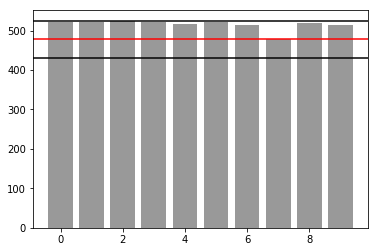

In [739]:
basic_plot2(c_totals=new_totals[:,0], sd=sd, oldmean=mean)

Showing the new mean flanked by desired standard deviation:

515.2 (47.34, 12.867012085173464)
[521 521 525 522 517 522 515 478 518 513]


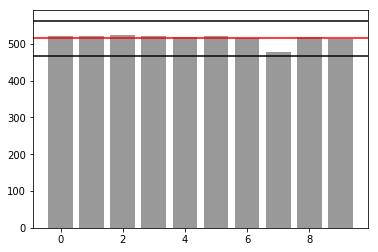

In [740]:
basic_plot2(c_totals=new_totals[:,0], sd=sd)

Looks like the algorithm mechanics are working as they should. Now to do the dataframe resample bit.

In [745]:
diffs = new_totals - c_totals
diffs[:,0]

array([ 15,  13,   0,  13,  31,  11,  44, 212,  30,  49])

Adding to a single category:

In [749]:
cat_pops['cat'][0]

'deer'

In [750]:
cat_pops

,cat,pop
0,deer,506
1,horse,508
2,frog,525
3,cat,509
4,truck,486
5,ship,511
6,airplane,471
7,dog,266
8,automobile,488
9,bird,464


In [759]:
# cats = cat_pops['cat'].values
idx = 0; cat = cat_pops['cat'].values[idx]
cat

'deer'

New Totals says the 'deer' category should have 15 elements added to it, bringing a total of 506 to 521 (I'm a bit paranoid about numerical stability):

In [764]:
cat_pops.iloc[idx]['pop'], new_totals[idx][0]

(506, 521)

Grab a random sample of 15 elements from the original dataset for 'deer':

In [782]:
copy_idxs = np.random.choice(np.where(df['class'] == cat)[0], size=diffs[idx], replace=False)
copy_idxs

array([34346, 35384, 37827, 36420, 37771, 37047, 34198, 34865, 36252,
       37255, 37010, 34754, 34176, 35629, 38172])

In [783]:
copyrows = df.iloc[copy_idxs]

In [784]:
copyrows

,file,class
34346,deer/44641_deer.png,deer
35384,deer/3868_deer.png,deer
37827,deer/19897_deer.png,deer
36420,deer/25216_deer.png,deer
37771,deer/42982_deer.png,deer
37047,deer/35743_deer.png,deer
34198,deer/36008_deer.png,deer
34865,deer/27258_deer.png,deer
36252,deer/24967_deer.png,deer
37255,deer/13428_deer.png,deer


Holy shit it works.

In [787]:
tmpdf = skewed_df.copy()
tmpdf.describe()

,file,class
count,4734,4734
unique,4734,10
top,horse/22789_horse.png,frog
freq,1,525


In [788]:
tmpdf.append(copyrows).describe()

,file,class
count,4749,4749
unique,4748,10
top,deer/35743_deer.png,frog
freq,2,525


In [791]:
tmpdf = tmpdf.append(copyrows)
tmpdf.iloc[-16:]

,file,class
34133,deer/36514_deer.png,deer
34346,deer/44641_deer.png,deer
35384,deer/3868_deer.png,deer
37827,deer/19897_deer.png,deer
36420,deer/25216_deer.png,deer
37771,deer/42982_deer.png,deer
37047,deer/35743_deer.png,deer
34198,deer/36008_deer.png,deer
34865,deer/27258_deer.png,deer
36252,deer/24967_deer.png,deer


Looks good. Now for all categories.

In [810]:
cats = cat_pops['cat'].values
copy_idxs = []
for i,cat in enumerate(cats):
    diff = diffs[i]
    copy_idxs.extend(np.random.choice(np.where(df['class'] == cat)[0], size=diff, replace=False))
len(copy_idxs)

418

In [811]:
new_totals.sum() - c_totals.sum()

418

In [814]:
copyrows = df.iloc[copy_idxs]
copyrows.count()

file     418
class    418
dtype: int64

In [818]:
copyrows.sample(n=5)

,file,class
6861,dog/42691_dog.png,dog
18405,airplane/25212_airplane.png,airplane
6379,dog/23967_dog.png,dog
4885,dog/37623_dog.png,dog
11506,truck/29574_truck.png,truck


Moment of truth: adding it back together and counting the result:

In [842]:
tmpdf = skewed_df.copy()
tmpdf.count()

file     4734
class    4734
dtype: int64

In [843]:
print(skewed_df.count()[0])
skewed_df = skewed_df.append(copyrows)
print(skewed_df.count()[0])

4734
5152


In [824]:
tmpdf.count()

file     5152
class    5152
dtype: int64

515.20 13.56


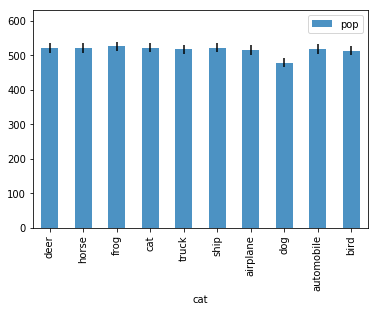

In [844]:
plot_pops(pops_from_df(skewed_df))

What the dataset looks like now:

515.2 (47.34, 12.867012085173464)
[521 521 525 522 517 522 515 478 518 513]


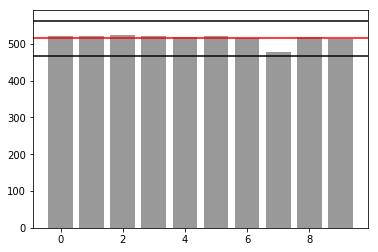

In [845]:
basic_plot2(c_totals=pops_from_df(skewed_df).as_matrix(columns=['pop'])[:,0], sd=sd)

And what it looks like with the original mean superimposed:

473.4 (47.34, 12.867012085173464)
[521 521 525 522 517 522 515 478 518 513]


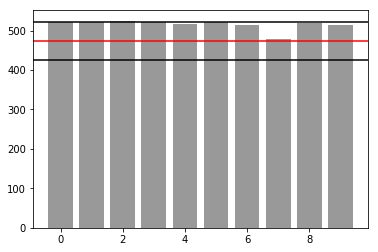

In [846]:
basic_plot2(c_totals=pops_from_df(skewed_df).as_matrix(columns=['pop'])[:,0], sd=sd, oldmean=c_totals.mean())

The dataset's class distribution has been smoothed out to within 1 desired standard deviation of the mean.

Automated dataset smoothing:

In [922]:
def smooth_csv_dataset(df, eps=0.1, full_df=None, catdx=1):
    """'Smooths' out a dataset by adding copied samples.
    
        For use with single-label classification (2-column) CSVs."""
    
    # result DF and sampling DF
    new_df  = df.copy()
    full_df = df if full_df is None else full_df
    # get category column name
    catcol = df.columns[catdx]
    
    # get category populations & calculate desired range
    cat_pops = pops_from_df(df)
    c_totals = cat_pops.as_matrix(columns=['pop'])
    sd       = eps * c_totals.mean()
    # Normalize category sizes
    c_norm     = c_totals/c_totals.max()
    new_mean   = c_totals.max() - sd
    new_totals = (2*sd * c_norm + (new_mean - sd)).astype(int)
    
    # Increase category sizes by differences
    diffs     = new_totals - c_totals
    cats      = cat_pops['cat'].values
    copy_idxs = []
    
    for i,cat in enumerate(cats):
        diff         = diffs[i]
        cat_idxs     = np.where(full_df[catcol]==cat)[0]
        full_cat_pop = len(cat_idxs)
        
        # if the difference is more than Nx greater, copy the whole category N times
        if diff > full_cat_pop:
            n_copy = int(diff) // full_cat_pop
            diff  -= n_copy * full_cat_pop
#             import pdb;pdb.set_trace()
            for i in range(n_copy): copy_idxs.extend(cat_idxs)
        copy_idxs.extend(np.random.choice(cat_idxs, size=diff, replace=False))
    
    copy_rows = full_df.iloc[copy_idxs]
    new_df    = new_df.append(copy_rows)
    
    return new_df

In [876]:
int(np.array([1]))

1

In [867]:
tmp = []
arr = [1,2,3]
ndarr = np.array(arr)
# tmp.extend(arr)
# tmp.extend(ndarr)
tmp.extend(np.array([1,2,3]))
tmp

[1, 2, 3]

Testing:

In [500]:
df = generate_csv(PATH)

In [848]:
skewed_df = df.sample(n=5000)
counts = pops_from_df(skewed_df); counts.mean()[0], counts.std()[0]

drop_idxs = np.where(skewed_df['class']=='dog')[0]
drop_idxs = np.random.choice(drop_idxs, size=len(drop_idxs)//2, replace=False)

skewed_df.drop(skewed_df.index[drop_idxs], inplace=True)
skewed_df.count()[0], np.where(skewed_df['class']=='dog')[0].shape[0]

(4755, 245)

475.5 (47.550000000000004, 80.82109873046765)
[515 245 452 494 485 495 505 547 532 485]


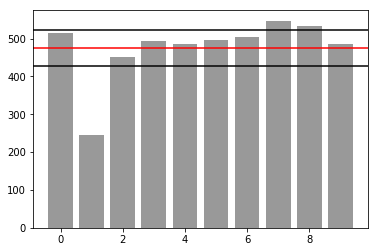

In [913]:
cat_pops = pops_from_df(skewed_df); c_totals = cat_pops.as_matrix(columns=['pop']); sd=c_totals.mean()*eps
basic_plot2(c_totals=c_totals[:,0], sd=sd)

Without a 'full' base dataset:

In [918]:
eps * c_totals.mean()

47.550000000000004

In [919]:
c_totals.max()

547

In [932]:
smooth_df = smooth_csv_dataset(skewed_df)

In [933]:
smooth_df.count()[0]

5341

In [934]:
oldmean

475.5

In [935]:
c_totals.mean()

534.1

I got a little confused looking at these plots, and realized I wasn't actually displaying or calculating the 'old' mean: more of a 'pseudomean'. The 'oldmean' parameter to the plot ('new_mean' inside the smoother function) *is* the pseudomean.

Although it's what I meant, I'm not actually asking for the dataset to be within 1 desired standard deviation from the mean. I'm asking that *no element of the dataset be less than 2 desired standard deviations from the maximum.*

That also means nothing is further than ±1 standard deviation from the new *actual* mean. So I'm in effect imposing 2 constraints: 
1. Nothing is further than 1 stdev from the (actual) mean, 
2. and the minumum is within 2 stdevs of the maximum.

499.45 (47.550000000000004, 14.088647912415158)
[541 494 530 537 536 537 539 547 544 536]


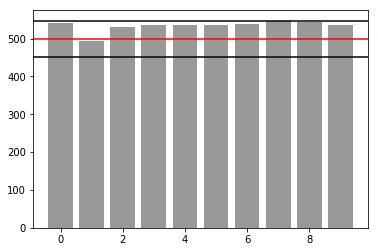

In [936]:
# Smoothed dataset is now
cat_pops = pops_from_df(smooth_df); c_totals = cat_pops.as_matrix(columns=['pop'])
basic_plot2(c_totals=c_totals[:,0], sd=sd, oldmean=c_totals.max()-sd)

534.1 (47.550000000000004, 14.088647912415158)
[541 494 530 537 536 537 539 547 544 536]


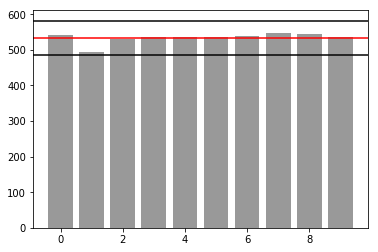

In [923]:
cat_pops = pops_from_df(smooth_df); c_totals = cat_pops.as_matrix(columns=['pop'])
basic_plot2(c_totals=c_totals[:,0], sd=sd)

With a 'full' base dataset:

In [940]:
%time smooth_df = smooth_csv_dataset(skewed_df, full_df=df)

CPU times: user 74.1 ms, sys: 3.08 ms, total: 77.2 ms
Wall time: 76.5 ms


499.45 (47.550000000000004, 14.088647912415158)
[541 494 530 537 536 537 539 547 544 536]


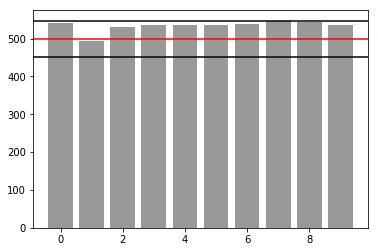

In [942]:
# entire dataset is within 2 stdevs of the maximum
cat_pops = pops_from_df(smooth_df); c_totals = cat_pops.as_matrix(columns=['pop'])
basic_plot2(c_totals=c_totals[:,0], sd=sd, oldmean=c_totals.max()-sd)

534.1 (47.550000000000004, 14.088647912415158)
[541 494 530 537 536 537 539 547 544 536]


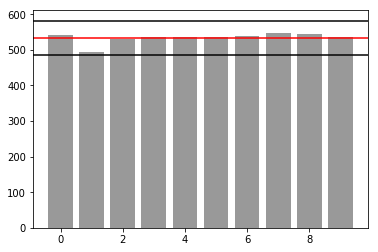

In [941]:
# entire dataset is within 1 stdev of the mean
cat_pops = pops_from_df(smooth_df); c_totals = cat_pops.as_matrix(columns=['pop'])
basic_plot2(c_totals=c_totals[:,0], sd=sd)

In [945]:
smooth_df.describe()

,file,class
count,5341,5341
unique,5287,10
top,dog/14963_dog.png,frog
freq,2,547


In [949]:
smooth_df.count()[0], skewed_df.count()[0]

(5341, 4755)

## Scrap

In [764]:
cat_pops.iloc[idx]['pop'], new_totals[idx][0]

(506, 521)

Grab a random sample of 15 elements from the original dataset for 'deer':

In [782]:
copy_idxs = np.random.choice(np.where(df['class'] == cat)[0], size=diffs[idx], replace=False)
copy_idxs

array([34346, 35384, 37827, 36420, 37771, 37047, 34198, 34865, 36252,
       37255, 37010, 34754, 34176, 35629, 38172])

In [783]:
copyrows = df.iloc[copy_idxs]

In [ ]:
# randomly sample from dataset to fill the difference
adds = []
diffs = new_totals - c_totals
for i,diff in enumerate(diffs):
    add = np.random.choice(df[catcol]==#TODO)

In [704]:
c_totals[np.argmin(c_totals)], c_normd[np.argmin(c_totals)]

(array([266]), array([0.56189269]))

In [ ]:
# normalize wrt max
c_normd = c_totals/c_totals.max()

# set floor as 2sd below max


In [702]:
cmin = c_totals[np.argmin(c_totals)]
cnormin = c_normd[np.argmin(c_totals)]

2*sd * cnormin

array([5.2288])

Too many values are being reduced. My algorithm isn't perfect for the job. *But*: what if I just take the max of the result? What does the mean & stdv look like then?

In [693]:
maxs = np.max((c_totals, new_totals), axis=0)
print(maxs.mean(), maxs.std())
list(zip(*maxs))[0]

491.9 24.570103784884587


(506, 508, 525, 509, 486, 511, 476, 435, 488, 475)

No values have increased beyond the original max, and all

In [695]:
maxs.min() - maxs.mean(), maxs.max() - maxs.mean()

(-56.89999999999998, 33.10000000000002)

In [646]:
c_totals.mean(), mean

(473.4, 477.65999999999997)

In [638]:
new_totals

array([[483],
       [483],
       [487],
       [484],
       [479],
       [484],
       [476],
       [435],
       [479],
       [475]])

In [490]:
## prototyping: dummy dataset variation
c_totals = np.random.randint(1000, 3000, size=10)
# calculate mean, actual & desired standard deviation
# mean = c_totals.mean()
# sa   = c_totals.std()
sd   = eps * mean

# normalize category sizes
c_normd = c_totals/c_totals.mean() - c_totals.min()/c_totals.max()
mean = c_totals.max() - sd
new_totals = (2*sd * c_normd + (mean - sd)).astype(int)

# randomly sample from dataset to fill the difference
adds = []
diffs = new_totals - c_totals
for i,diff in enumerate(diffs):
    add = np.random.choice(df[catcol]==#TODO)

array([1330, 1122,  235, 1282, 1262, 1055,  166,  838, 1381,  975])

In [612]:
cat_pops.std()

pop    75.339528
dtype: float64

In [613]:
c_totals

array([[506],
       [508],
       [525],
       [509],
       [486],
       [511],
       [471],
       [266],
       [488],
       [464]])

In [614]:
cat_pops

,cat,pop
0,deer,506
1,horse,508
2,frog,525
3,cat,509
4,truck,486
5,ship,511
6,airplane,471
7,dog,266
8,automobile,488
9,bird,464


In [615]:
def plot_pops(df, print_ms=True):
    if print_ms: print(f"{df.mean()[0]:.2f} {df.std()[0]:.2f}")
    df.plot.bar(x=df[df.columns[0]], ylim=(0,1.2*df[df.columns[1]].values.max()), 
            yerr=max(df.mean()[0]*0.005, df.std()[0]), alpha=.8)
    df.mean()[0], df.std()[0]

In [616]:
cat_pops.mean()

pop    473.4
dtype: float64

In [617]:
cat_pops.std()

pop    75.339528
dtype: float64

In [618]:
cat_pops.as_matrix(columns=['pop']).std()

71.47335167739092

In [619]:
cat_pops.as_matrix(columns=['pop'])

array([[506],
       [508],
       [525],
       [509],
       [486],
       [511],
       [471],
       [266],
       [488],
       [464]])

In [629]:
cat_pops.as_matrix(columns=['pop']).mean(), cat_pops.as_matrix(columns=['pop']).std()

(473.4, 71.47335167739092)

In [626]:
cat_pops['pop'].sum()

4734

In [628]:
cat_pops['pop'].mean(), cat_pops['pop'].std()

(473.4, 75.33952776892383)

In [599]:
c_totals.sum()

4734

In [490]:
## prototyping: dummy dataset variation
c_totals = np.random.randint(1000, 3000, size=10)
# calculate mean, actual & desired standard deviation
# mean = c_totals.mean()
# sa   = c_totals.std()
sd   = eps * mean

# normalize category sizes
c_normd = c_totals/c_totals.mean() - c_totals.min()/c_totals.max()
mean = c_totals.max() - sd
new_totals = (2*sd * c_normd + (mean - sd)).astype(int)

# randomly sample from dataset to fill the difference
adds = []
diffs = new_totals - c_totals
for i,diff in enumerate(diffs):
    add = np.random.choice(df[catcol]==)

array([1330, 1122,  235, 1282, 1262, 1055,  166,  838, 1381,  975])

In [496]:
tmp = []
tmp.append(df.iloc[5:10])
tmp

[                file class
 5   cat/3863_cat.png   cat
 6  cat/45897_cat.png   cat
 7  cat/49197_cat.png   cat
 8   cat/1846_cat.png   cat
 9   cat/8760_cat.png   cat]

In [497]:
pd.DataFrame(tmp)

,0
0,file class 5 cat/3863_cat.pn...


1936.1 (193.61, 608.770145457216)
[2648 1644 1261 1311 1215 2895 2227 2026 1475 2659]
2732.4879792746115 (193.61, 121.75402909144326)
[2874.86797927 2674.06797927 2597.46797927 2607.46797927 2588.26797927
 2924.26797927 2790.66797927 2750.46797927 2640.26797927 2877.06797927]


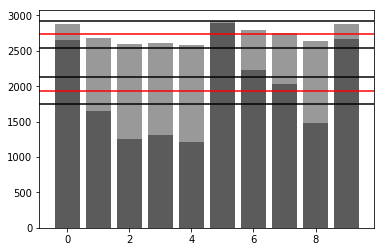

In [463]:
eps = 0.1

c_totals = np.random.randint(1000, 3000, size=10)
mean = c_totals.mean()
sa   = c_totals.std()
sd   = eps * mean

basic_plot()

c_normd = c_totals/c_totals.mean() - c_totals.min()/c_totals.max()
mean = c_totals.max() - sd
c_totals = (2*sd * c_normd + (mean - sd))

basic_plot()

First time I got the normalization algorithm working:

2159.1 (215.91, 556.2047195053275)
[2974 2803 2686 2567 2208 1818 1286 1631 1521 2097]


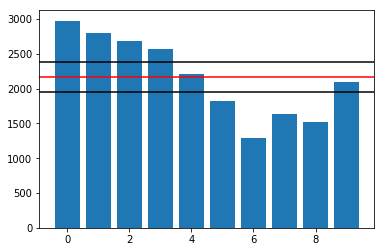

In [386]:
eps = 0.1

c_totals = np.random.randint(1000, 3000, size=10)
mean = c_totals.mean()
sa   = c_totals.std()
sd   = eps * mean

basic_plot()

In [412]:
c_totals / c_totals.mean() - (c_totals.min()/c_totals.max())

array([0.94501152, 0.86581186, 0.81162261, 0.75650705, 0.59023407,
       0.40960325, 0.16320429, 0.32299309, 0.27204593, 0.53882376])

In [413]:
c_normd = c_totals/c_totals.mean() - c_totals.min()/c_totals.max()
c_normd

array([0.94501152, 0.86581186, 0.81162261, 0.75650705, 0.59023407,
       0.40960325, 0.16320429, 0.32299309, 0.27204593, 0.53882376])

In [414]:
new_mean = c_totals.max() - sd
new_mean

2758.09

In [420]:
new_totals = (2*sd * c_normd + (new_mean - sd))
new_totals

array([2950.25487559, 2916.05487559, 2892.65487559, 2868.85487559,
       2797.05487559, 2719.05487559, 2612.65487559, 2681.65487559,
       2659.65487559, 2774.85487559])

2787.274875588433 (215.91, 111.2409439010655)
[2950.25487559 2916.05487559 2892.65487559 2868.85487559 2797.05487559
 2719.05487559 2612.65487559 2681.65487559 2659.65487559 2774.85487559]


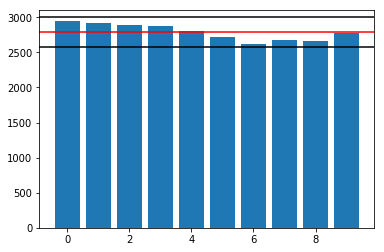

In [427]:
c_totals = new_totals
mean = new_mean

basic_plot()

In [390]:
c_norm = c_totals / np.linalg.norm(c_totals, ord=np.inf)
c_range= c_norm * sd*2
c_range

array([431.82      , 406.99107599, 390.00286483, 372.72425689,
       320.59803631, 263.97066577, 186.72512441, 236.81856759,
       220.84674512, 304.48101547])

In [392]:
c_range.max()

True

New algorithm:
```
set max to max category.
calculate new mean as 1 σδ below max.
normalize dataset to 1 σδ of new mean.
```

normalization:
- % distance to new mean = % distance to original mean, with max distance set by σδ.
    
- This means that categories further from the original mean than the max is from it will be clamped to new mean - σδ.

2721.04 (272.104, 455.21449889035824)
[2257 1746 2911 1583 1453 2064 1231 1741 1809 2201]


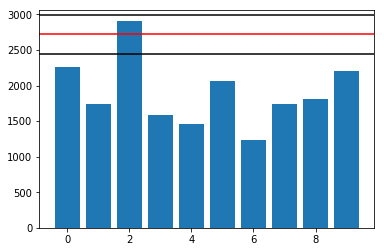

In [385]:
c_max = c_totals.max()
new_mean = c_max - sd

c_norm = c_totals/np.linalg.norm(c_totals, ord=np.inf)
c_total = c_norm * sd + new_mean

# for i,c_tot in enumerate(c_totals):
#     c_totals[i] = max(new_mean-sd, min())
#     if c_tot < mean:
#         c_totals[i] = max(new_mean-sd, c_tot*(c_tot/mean)/(mean/(new_mean+sd)))
#     elif c_tot > mean:
#         c_totals[i] = max(new_mean-sd, c_tot*(c_tot/c_max)/(c_max/(new_mean+sd)))

mean = new_mean
sa   = c_totals.std()
sd   = eps*mean

basic_plot()

2673.48 (267.348, 133.56885864601824)
[2449 2449 2449 2449 2497 2449 2449 2449 2449 2897]


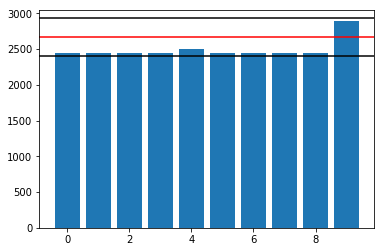

In [313]:
c_max = c_totals.max()
new_mean = c_max - sd
for i,c_tot in enumerate(c_totals):
#     c_totals[i] = max(new_mean-sd, min())
    if c_tot < mean:
        c_totals[i] = max(new_mean-sd, c_tot*(c_tot/mean)/(mean/(new_mean+sd)))
    elif c_tot > mean:
        c_totals[i] = max(new_mean-sd, c_tot*(c_tot/c_max)/(c_max/(new_mean+sd)))

mean = new_mean
sa   = c_totals.std()
sd   = eps*mean

basic_plot()

In [491]:
diffs

array([1330, 1122,  235, 1282, 1262, 1055,  166,  838, 1381,  975])

In [479]:
# cat_pops = pops_from_df(csv, colnames=None)
cat_pops = pops_from_df(csv)

In [480]:
cat_pops.as_matrix(columns=['pop'])

array([[4250],
       [4250],
       [4250],
       [4250],
       [4250],
       [4250],
       [4250],
       [4250],
       [4250],
       [4250]])

In [481]:
totals = cat_pops.as_matrix(columns=['pop'])

In [483]:
totals.std()

0.0

In [484]:
cat_pops

,cat,pop
0,cat,4250
1,dog,4250
2,truck,4250
3,bird,4250
4,airplane,4250
5,ship,4250
6,frog,4250
7,horse,4250
8,deer,4250
9,automobile,4250


In [485]:
for cat in cat_pops.as_matrix(columns=['cat']):
    print(cat)

['cat']
['dog']
['truck']
['bird']
['airplane']
['ship']
['frog']
['horse']
['deer']
['automobile']


In [489]:
df['class']==cat[0]

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
42470     True
42471     True
42472     True
42473     True
42474     True
42475     True
42476     True
42477     True
42478     True
42479     True
42480     True
42481     True
42482     True
42483     True
42484     True
42485     True
42486     True
42487     True
42488     True
42489     True
42490     True
42491     True
42492     True
42493     True
42494     True
42495     True
42496     True
42497     True
42498     True
42499     True
Name: class, Length: 42500, dtype: bool

In [306]:
c_max = 150
c_tot = c_max
sd = 20
new_mean = c_max - sd

c_tot*(c_tot/c_max)/(c_max/(new_mean+sd))

150.0

In [309]:
c_max

2704

In [311]:
new_mean + sd

2775.487

In [298]:
c_totals.mean()

2575.0

In [299]:
mean

2787.3

2787.3 (278.73, 0.0)
[2575 2575 2575 2575 2575 2575 2575 2575 2575 2575]


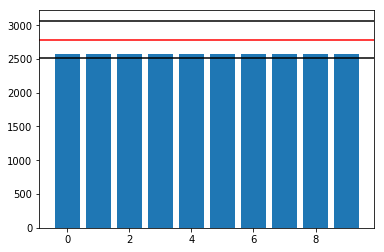

In [297]:
basic_plot()

In [287]:
(70/100)/(100/150)

1.05

In [294]:
(150/100)/(100/150)

2.25

Standard Deviation formula:
<img src="https://www.mathsisfun.com/data/images/standard-deviation-formula.gif" >

So, I want σ to be `eps` percent of the total dataset. The main factor in this eq is the difference from the mean. And it's squared, so there's a high penalty on being off-mean. What makes this not-simple is σ and μ affect each other, so there's a differential equation somewhere that has to be solved.

1st algorithm idea:
```
σ: standard deviation; α: actual; δ: desired

k = σδ/2

While the σα is greater than σδ:

    For each category:
        if that category is below the mean by more than 1 σδ:
            add k σδ of random copies to that category

    recalculate mean
    recalculate σδ

    If no categories are below the mean by more than 1 σδ:
        k = k/2
```

I'm concerned about updates. The 'perfect' numerical solution is to recalculate the mean/stdv every time `k` is added, and to keep `k` at 1. This is also a worst-case scenario for time. Setting `k=σδ/2` is my attempt at striking a balance between 'resolution' and speed.

2191.6 (219.16, 501.9958565566055)
[2187 1255 1965 2302 2380 2358 2208 2954 2836 1471]


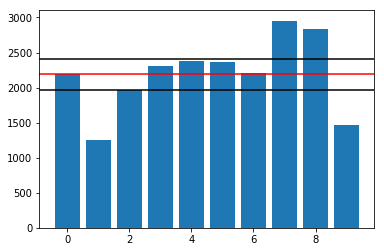

In [338]:
eps = 0.1

c_totals = np.random.randint(1000, 3000, size=10)
mean = c_totals.mean()
sa   = c_totals.std()
sd   = eps * mean

k = sd/2

iters = 0

basic_plot()

this initial version of the algorithm stops progressing when the minimum total is within 1 desired standard deviation of the mean. However, if any totals are more than a desired stdv from the mean, the actual stdv will be greater than that desired. This algorithm will fail to converge whenever this condition exists.

iterations: 11
2387.8 (238.78000000000003, 262.88126597382325)
[2187 2236 2183 2302 2380 2358 2208 2954 2836 2234]


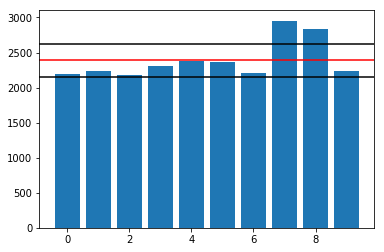

In [349]:
# while sa > sd:
k_OK = False
for i,c_tot in enumerate(c_totals):
    if mean - c_tot > sd:
        c_totals[i] += k
        k_OK = True
        
# update
mean = c_totals.mean()
sa   = c_totals.std()
sd   = eps * mean

# check resolution change
if not k_OK: k /= 2

iters += 1; print(f'iterations: {iters}')
basic_plot()

In [350]:
k

27.395

In [146]:
k

0.363515625

In [29]:
cat_pops

,cat,pop
0,cat,4250
1,dog,4250
2,truck,4250
3,bird,4250
4,airplane,4250
5,ship,4250
6,frog,4250
7,horse,4250
8,deer,4250
9,automobile,4250


In [21]:
data = np.array([1000, 1500, 700, 1200, 1100, 900])
data.mean(), data.std()

(1066.6666666666667, 249.44382578492943)

In [26]:
ε = 0.1
σ = data.mean() * ε; σ

106.66666666666669

In [277]:
pops_from_df(df.sample(n=1000))

,cat,pop
0,bird,90
1,ship,105
2,cat,102
3,frog,102
4,automobile,99
5,horse,91
6,truck,97
7,deer,117
8,airplane,108
9,dog,89


In [375]:
n = 100

catdx=1
catcol = df.columns[catdx]
cats = df[catcol].unique()

df_slice = df[catcol]

keep_idxs = np.array([], dtype=np.int64) ## np.dtype(int) --> dtype('int64')
for cat in cats:
    keep_idxs = np.concatenate((keep_idxs, np.random.choice(np.where(df_slice==cat)[0], size=n, replace=False)))

In [385]:
np.where(df_slice==cat)[0]

array([38250, 38251, 38252, ..., 42497, 42498, 42499])

In [384]:
len(np.where(df_slice==cat)[0])

4250

In [390]:
np.array([], dtype='int64'), np.array([], dtype=np.int64)

(array([], dtype=int64), array([], dtype=int64))

In [377]:
keep_idxs.shape

(1000,)

In [380]:
df.iloc[keep_idxs].head(n=10)

,file,class
1212,cat/32702_cat.png,cat
3603,cat/39013_cat.png,cat
2162,cat/5065_cat.png,cat
2046,cat/47554_cat.png,cat
2525,cat/5502_cat.png,cat
93,cat/32423_cat.png,cat
1000,cat/18970_cat.png,cat
2507,cat/2083_cat.png,cat
771,cat/19922_cat.png,cat
3884,cat/45850_cat.png,cat


In [381]:
df.iloc[keep_idxs].sample(n=10)

,file,class
7354,dog/28740_dog.png,dog
38808,automobile/42438_automobile.png,automobile
1072,cat/41673_cat.png,cat
13373,bird/8321_bird.png,bird
30367,horse/19089_horse.png,horse
28762,frog/20297_frog.png,frog
20112,airplane/41345_airplane.png,airplane
5926,dog/7472_dog.png,dog
34833,deer/18875_deer.png,deer
15485,bird/14946_bird.png,bird


In [374]:
np.dtype(type(3))

dtype('int64')

In [376]:
keep_idxs[:100]

array([1212, 3603, 2162, 2046, 2525,   93, 1000, 2507,  771, 3884, 1585,
       2912, 3028,  982, 3309, 1072, 4057,  825, 2564, 3107,   77,  767,
        997, 3694, 2481, 2382, 3043, 3716, 3621, 2356, 2052, 1666, 2901,
       3226, 1771, 3892,  893,  984, 3541, 2205, 2203, 4204,  484, 1039,
       1787, 1927, 3474,  578, 1190, 2221, 3273, 2151,   35,  677, 2006,
       1774,  583, 3697,  403, 3899, 2748, 3850, 1392,   84,  819,  338,
        939, 2811, 1995, 3407, 2153, 3354, 3842, 1176, 3324, 2386,  197,
       2875, 2634, 2375, 3219, 2606,  657, 3614, 1268, 1887, 3122, 2855,
         95, 2668, 1413, 1763, 2014, 1710,  700,  401, 2624, 2309,  650,
       3701])

In [351]:
np.concatenate(keep_idxs, np.random.choice(np.where(df_slice==cat)[0], size=n, replace=False))

TypeError: only integer scalar arrays can be converted to a scalar index

In [355]:
np.random.choice(np.where(df_slice==cat)[0], size=n, replace=False)

array([ 649,  909, 3390,  377, 1873, 4088, 3097, 2128, 2550, 2647, 3446,
        920, 2876, 3022, 2431,   16,  866, 3886, 1753,  339, 2684, 3358,
       3514, 3127, 1155,  837, 2827,  724,  487, 1114, 2674, 2455,  391,
       1143, 2353,  279, 1566,  838, 3808,  974,   35,  456,  829, 1755,
       3984,   41,  794, 2937,  307, 2745,   40, 2961, 1691, 1818, 3538,
       3718,  536, 3196, 3880, 1179, 3325,  672, 1607,  861, 1905, 1749,
        732, 2645, 4022,  968, 3445, 3611, 1892,  972,  439, 3835, 1444,
       3375, 1005, 1389, 2117, 1413, 1266, 2432, 2787, 2492,  912, 4086,
       1612, 3692, 3106,  538, 2894,  289, 1040,  870, 1866, 2189, 3222,
       2082])

In [337]:
keep_idxs = np.array([])

In [339]:
x = np.array([1,2,3,])

In [340]:
x.shape

(3,)

In [342]:
np.concatenate((keep_idxs, x))

array([1., 2., 3.])

In [298]:
catdx=1
catcol = df.columns[catdx]
cats = df[catcol].unique()
for cat in cats:
#     pops = [df[df[y]==cat].count()[0] for cat in cats]
    keepidx = np.where(df[df[catcol]==cat])
    break

In [334]:
df_slice = df[catcol]
keepidxs = np.random.choice(np.where(df_slice==cat)[0], size = 20, replace=False)

In [332]:
np.where(df_slice==cat)[0]

array([   0,    1,    2, ..., 4247, 4248, 4249])

In [327]:
df_slice

0               cat
1               cat
2               cat
3               cat
4               cat
5               cat
6               cat
7               cat
8               cat
9               cat
10              cat
11              cat
12              cat
13              cat
14              cat
15              cat
16              cat
17              cat
18              cat
19              cat
20              cat
21              cat
22              cat
23              cat
24              cat
25              cat
26              cat
27              cat
28              cat
29              cat
            ...    
42470    automobile
42471    automobile
42472    automobile
42473    automobile
42474    automobile
42475    automobile
42476    automobile
42477    automobile
42478    automobile
42479    automobile
42480    automobile
42481    automobile
42482    automobile
42483    automobile
42484    automobile
42485    automobile
42486    automobile
42487    automobile
42488    automobile


In [308]:
keepidx = np.where(df[df[catcol]==cat])
keepidx[0].shape

(8500,)

In [317]:
keepidx = df[df[catcol]==cat].as_matrix()[:,0]
keepidx.shape

(4250,)

In [318]:
keepidx[:n]

array(['cat/21851_cat.png', 'cat/45066_cat.png', 'cat/4835_cat.png', ...,
       'cat/46013_cat.png', 'cat/45379_cat.png', 'cat/49298_cat.png'],
      dtype=object)

In [319]:
keepidx = np.where(df[df[catcol]==cat])
keepidx[0][:10]

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

In [323]:
df.iloc[keepidx].head()

,file,class,file,class,file,class,file,class,file,class,...,file,class,file,class,file,class,file,class,file,class
0,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat,...,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat
0,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat,...,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat,cat/21851_cat.png,cat
1,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat,...,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat
1,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat,...,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat,cat/45066_cat.png,cat
2,cat/4835_cat.png,cat,cat/4835_cat.png,cat,cat/4835_cat.png,cat,cat/4835_cat.png,cat,cat/4835_cat.png,cat,...,cat/4835_cat.png,cat,cat/4835_cat.png,cat,cat/4835_cat.png,cat,cat/4835_cat.png,cat,cat/4835_cat.png,cat


In [261]:
list(zip(cats,pops))

[('cat', 4250),
 ('dog', 4250),
 ('truck', 4250),
 ('bird', 4250),
 ('airplane', 4250),
 ('ship', 4250),
 ('frog', 4250),
 ('horse', 4250),
 ('deer', 4250),
 ('automobile', 4250)]

In [210]:
list(zip(cats,pops))

[('cat', 4250),
 ('dog', 4250),
 ('truck', 4250),
 ('bird', 4250),
 ('airplane', 4250),
 ('ship', 4250),
 ('frog', 4250),
 ('horse', 4250),
 ('deer', 4250),
 ('automobile', 4250)]

In [248]:
rows=[]
for cat in catfolders:
    catpath = path/folder/cat
    fpaths  = list(map(lambda x: cat+'/'+x, os.listdir(catpath)))
    rows.extend(list(zip(fpaths,[labelmap[cat] for i in range(len(fpaths))])))

df = pd.DataFrame(rows, columns=['file','class'])

In [251]:
rows[0]

('cat/21851_cat.png', 'cat')

In [250]:
cols['cat']

('cat',
 'dog',
 'truck',
 'bird',
 'airplane',
 'ship',
 'frog',
 'horse',
 'deer',
 'automobile')

In [252]:
list(zip(cols['cat'],cols['pop']))

[('cat', 4250),
 ('dog', 4250),
 ('truck', 4250),
 ('bird', 4250),
 ('airplane', 4250),
 ('ship', 4250),
 ('frog', 4250),
 ('horse', 4250),
 ('deer', 4250),
 ('automobile', 4250)]

In [240]:
dictionary=cat_pops

cols = dict()
cols['cat'],cols['pop'] = zip(*dictionary.items())
# pd.DataFrame([cols['cat'],cols['pop']],columns=['cat','pop'])

AssertionError: 2 columns passed, passed data had 10 columns

In [236]:
cols

{'cat': ('cat',
  'dog',
  'truck',
  'bird',
  'airplane',
  'ship',
  'frog',
  'horse',
  'deer',
  'automobile'),
 'pop': (4250, 4250, 4250, 4250, 4250, 4250, 4250, 4250, 4250, 4250)}

In [238]:
pd.DataFrame(cols)

,cat,pop
0,cat,4250
1,dog,4250
2,truck,4250
3,bird,4250
4,airplane,4250
5,ship,4250
6,frog,4250
7,horse,4250
8,deer,4250
9,automobile,4250


In [239]:
cols['cat']

('cat',
 'dog',
 'truck',
 'bird',
 'airplane',
 'ship',
 'frog',
 'horse',
 'deer',
 'automobile')

In [224]:
cols = dict()
cols['cat'],cols['pop'] = zip(*cat_pops.items())

In [225]:
cols

{'cat': ('airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'),
 'pop': (4250, 4250, 4250, 4250, 4250, 4250, 4250, 4250, 4250, 4250)}

In [207]:
df=csv;xdx=0;ydx=1

x,y = df.columns[xdx],df.columns[ydx]
cats = df[y].unique()
print(cats)
pops = [df[df[y]==cat].count()[0] for cat in cats]

['cat' 'dog' 'truck' 'bird' 'airplane' 'ship' 'frog' 'horse' 'deer'
 'automobile']


In [177]:
csv[csv['class']=='cat'].count()

file     4250
class    4250
dtype: int64

In [179]:
csv.columns[1]

'class'

In [149]:
%%time
labelmap = None
folder='train'
path = PATH
# find categories
catfolders = [f for f in os.listdir(path/folder) if (path/folder/f).is_dir()]
if labelmap is None: labelmap = {cf:cf for cf in catfolders}

df = pd.DataFrame(columns=['file_path','class'])
rows = []

for cat in catfolders:
    catpath = path/folder/cat
    fpaths = list(map(lambda x: cat+'/'+x , os.listdir(catpath)))
#     fpaths  = list(map(str, catpath.iterdir()))
    rows.extend(list(zip(fpaths,[cat for i in range(len(fpaths))])))
    break

CPU times: user 5.45 ms, sys: 6.93 ms, total: 12.4 ms
Wall time: 12 ms


In [150]:
# rows

In [135]:
len(rows)

4250

In [136]:
df = pd.DataFrame(rows, columns=['file_path','class'])
df.head()

,file_path,class
0,data/cifar10/train/cat/21851_cat.png,cat
1,data/cifar10/train/cat/45066_cat.png,cat
2,data/cifar10/train/cat/4835_cat.png,cat
3,data/cifar10/train/cat/35804_cat.png,cat
4,data/cifar10/train/cat/24696_cat.png,cat


In [117]:
n=10
# fpaths[:n], [cat for i in range(n)]

list(zip(fpaths[:n],[cat for i in range(n)]))

[('data/cifar10/train/cat/21851_cat.png', 'cat'),
 ('data/cifar10/train/cat/45066_cat.png', 'cat'),
 ('data/cifar10/train/cat/4835_cat.png', 'cat'),
 ('data/cifar10/train/cat/35804_cat.png', 'cat'),
 ('data/cifar10/train/cat/24696_cat.png', 'cat'),
 ('data/cifar10/train/cat/3863_cat.png', 'cat'),
 ('data/cifar10/train/cat/45897_cat.png', 'cat'),
 ('data/cifar10/train/cat/49197_cat.png', 'cat'),
 ('data/cifar10/train/cat/1846_cat.png', 'cat'),
 ('data/cifar10/train/cat/8760_cat.png', 'cat')]

In [127]:
n = 2000

In [128]:
%%time
rows = []
rows1 = list(zip(fpaths[:n], [cat for i in range(n)]));
rows2 = list(zip(fpaths[n:2*n], [cat for i in range(n)]));
rows.append(rows1)
rows.append(rows2)
rows

CPU times: user 2.14 ms, sys: 34 µs, total: 2.17 ms
Wall time: 2.33 ms


In [129]:
%%time
rows = []
rows1 = list(zip(fpaths[:n], [cat for i in range(n)]));
rows2 = list(zip(fpaths[n:2*n], [cat for i in range(n)]));
rows.extend(rows1)
rows.extend(rows2)
rows

CPU times: user 644 µs, sys: 0 ns, total: 644 µs
Wall time: 655 µs


In [122]:
rows

[('data/cifar10/train/cat/21851_cat.png', 'cat'),
 ('data/cifar10/train/cat/45066_cat.png', 'cat'),
 ('data/cifar10/train/cat/4835_cat.png', 'cat'),
 ('data/cifar10/train/cat/35804_cat.png', 'cat'),
 ('data/cifar10/train/cat/24696_cat.png', 'cat'),
 ('data/cifar10/train/cat/3863_cat.png', 'cat'),
 ('data/cifar10/train/cat/45897_cat.png', 'cat'),
 ('data/cifar10/train/cat/49197_cat.png', 'cat'),
 ('data/cifar10/train/cat/1846_cat.png', 'cat'),
 ('data/cifar10/train/cat/8760_cat.png', 'cat'),
 ('data/cifar10/train/cat/21851_cat.png', 'cat'),
 ('data/cifar10/train/cat/45066_cat.png', 'cat'),
 ('data/cifar10/train/cat/4835_cat.png', 'cat'),
 ('data/cifar10/train/cat/35804_cat.png', 'cat'),
 ('data/cifar10/train/cat/24696_cat.png', 'cat'),
 ('data/cifar10/train/cat/3863_cat.png', 'cat'),
 ('data/cifar10/train/cat/45897_cat.png', 'cat'),
 ('data/cifar10/train/cat/49197_cat.png', 'cat'),
 ('data/cifar10/train/cat/1846_cat.png', 'cat'),
 ('data/cifar10/train/cat/8760_cat.png', 'cat')]

In [118]:
df = pd.DataFrame(list(zip(fpaths[:n],[cat for i in range(n)])), columns=['file_path','class'])

In [119]:
df

,file_path,class
0,data/cifar10/train/cat/21851_cat.png,cat
1,data/cifar10/train/cat/45066_cat.png,cat
2,data/cifar10/train/cat/4835_cat.png,cat
3,data/cifar10/train/cat/35804_cat.png,cat
4,data/cifar10/train/cat/24696_cat.png,cat
5,data/cifar10/train/cat/3863_cat.png,cat
6,data/cifar10/train/cat/45897_cat.png,cat
7,data/cifar10/train/cat/49197_cat.png,cat
8,data/cifar10/train/cat/1846_cat.png,cat
9,data/cifar10/train/cat/8760_cat.png,cat


In [109]:
df = pd.DataFrame(rows[0],rows[1], columns=['file_path','class'])

AssertionError: 2 columns passed, passed data had 4250 columns

In [106]:
df

,0,1,2,3,4,5,6,7,8,9,...,4240,4241,4242,4243,4244,4245,4246,4247,4248,4249
0,data/cifar10/train/cat/21851_cat.png,data/cifar10/train/cat/45066_cat.png,data/cifar10/train/cat/4835_cat.png,data/cifar10/train/cat/35804_cat.png,data/cifar10/train/cat/24696_cat.png,data/cifar10/train/cat/3863_cat.png,data/cifar10/train/cat/45897_cat.png,data/cifar10/train/cat/49197_cat.png,data/cifar10/train/cat/1846_cat.png,data/cifar10/train/cat/8760_cat.png,...,data/cifar10/train/cat/2699_cat.png,data/cifar10/train/cat/42321_cat.png,data/cifar10/train/cat/24597_cat.png,data/cifar10/train/cat/29004_cat.png,data/cifar10/train/cat/40304_cat.png,data/cifar10/train/cat/12904_cat.png,data/cifar10/train/cat/48928_cat.png,data/cifar10/train/cat/40314_cat.png,data/cifar10/train/cat/20196_cat.png,data/cifar10/train/cat/33964_cat.png
1,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,...,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat


In [75]:
files = generate_csv(PATH)
cat = 'cat'
path = PATH
folder = 'train'

In [76]:
files_np = np.array(files)

In [83]:
catpath = path/folder/cat;
catpath

PosixPath('data/cifar10/train/cat')

In [166]:
list(map(str, catpath.iterdir()))[:20]

['data/cifar10/train/cat/21851_cat.png',
 'data/cifar10/train/cat/45066_cat.png',
 'data/cifar10/train/cat/4835_cat.png',
 'data/cifar10/train/cat/35804_cat.png',
 'data/cifar10/train/cat/24696_cat.png',
 'data/cifar10/train/cat/3863_cat.png',
 'data/cifar10/train/cat/45897_cat.png',
 'data/cifar10/train/cat/49197_cat.png',
 'data/cifar10/train/cat/1846_cat.png',
 'data/cifar10/train/cat/8760_cat.png',
 'data/cifar10/train/cat/7493_cat.png',
 'data/cifar10/train/cat/39751_cat.png',
 'data/cifar10/train/cat/16851_cat.png',
 'data/cifar10/train/cat/1856_cat.png',
 'data/cifar10/train/cat/7483_cat.png',
 'data/cifar10/train/cat/33903_cat.png',
 'data/cifar10/train/cat/44127_cat.png',
 'data/cifar10/train/cat/46757_cat.png',
 'data/cifar10/train/cat/36970_cat.png',
 'data/cifar10/train/cat/34689_cat.png']

In [46]:
cat_pops_np = np.array([[k,v] for k,v in cat_pops.items()])

In [47]:
cat_pops_np[:,1]

array(['4250', '4250', '4250', '4250', '4250', '4250', '4250', '4250',
       '4250', '4250'], dtype='<U10')

In [49]:
from collections import defaultdict
cat_pops_dict = defaultdict(lambda x: [])
for k,v in cat_pops.items():
    cat_pops_dict[k] = v

In [50]:
cat_pops_dict

defaultdict(<function __main__.<lambda>(x)>,
            {'airplane': 4250,
             'automobile': 4250,
             'bird': 4250,
             'cat': 4250,
             'deer': 4250,
             'dog': 4250,
             'frog': 4250,
             'horse': 4250,
             'ship': 4250,
             'truck': 4250})

In [48]:
cat_pops_dict = {'cat':k,'pop':v for k,v in cat_pops.items()}

SyntaxError: invalid syntax (<ipython-input-48-11346347af81>, line 1)

In [29]:
df = pd.DataFrame({'cat':[cat for cat in cat_pops.keys()],'pop':[pop for pop in cat_pops.values()]})

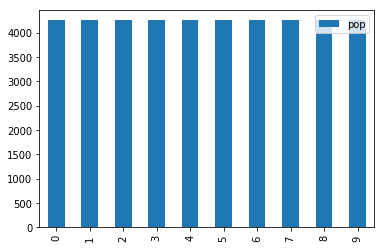

In [30]:
df.plot.bar()

In [ ]:
df = pd.DataFrame({'cat':})

In [35]:
cat_pops_np[:,0]

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [37]:
df = pd.DataFrame({'cat':cat_pops_np[:,0],'pop':cat_pops_np[:,1]})

In [44]:
df.

0    4250
1    4250
2    4250
3    4250
4    4250
5    4250
6    4250
7    4250
8    4250
9    4250
Name: pop, dtype: object

In [43]:
df.plot.bar()

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
def csv_smooth_data(path, threshold):
    